I want to calculate the value of a Call Option for Microsoft stock (MSFT) using a combination of Monte Carlo Simulation and Euler Discretization. We will use Monte Carlo to simulate 1000 possible future option prices for the next 2 years (500 trading days). We will then average the payoff. 

In [2]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
stock = ['MSFT']
data = pd.DataFrame()
data[stock] = wb.DataReader(stock, data_source = 'yahoo', start = '2010-1-1')['Adj Close']
data.tail()

,MSFT
Date,
2020-05-04,178.839996
2020-05-05,180.759995
2020-05-06,182.539993
2020-05-07,183.600006
2020-05-08,184.679993


In [5]:
log_returns = np.log(1 + data.pct_change())

## $ S_t = S_{t-1} . e^{(r-0.5.stdev^2).delta_t +stdev.\sqrt{delta_t} . Z_t} $

$r$ = risk-free rate;
<br>
$delta_t$ = fixed time interval;
<br>
$Z_t$ follows a standard normal distribution

In [6]:
r = 0.01
T = 2
t_intervals = 500
delta_t = T/t_intervals
iterations = 1000

In [20]:
stdev = log_returns.std() * 250 ** 0.5
stdev = stdev.values
stdev

array([0.25009264])

Lets create a 501 by 1000 matrix based on the standard normal distribution values. Create a new matrix, S, filled with 0s and then let the first row of this new matrix be the last value from our historical dataset.

In [13]:
Z = np.random.standard_normal((t_intervals + 1, iterations))
S = np.zeros_like(Z)
S0 = data.iloc[-1]
S[0] = S0
S

array([[184.67999268, 184.67999268, 184.67999268, ..., 184.67999268,
        184.67999268, 184.67999268],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [22]:
S.shape

(501, 1000)

This generates a 1000 different versions of the stock prices for the next 500 trading days (2 years)

In [24]:
for t in range(1, t_intervals + 1):
    S[t] = S[t-1] * np.exp((r - 0.5 * stdev**2) * delta_t + stdev * delta_t ** 0.5 * Z[t])
S

array([[184.67999268, 184.67999268, 184.67999268, ..., 184.67999268,
        184.67999268, 184.67999268],
       [187.89786904, 181.07860833, 191.60296928, ..., 184.87209157,
        184.07274648, 180.94238953],
       [184.20033397, 185.08391949, 189.13552571, ..., 184.00127802,
        186.3812961 , 180.84118546],
       ...,
       [232.9799642 , 118.66293517, 162.8111324 , ..., 195.03762044,
        131.58313233, 190.41321149],
       [233.00342346, 121.16234444, 161.80184354, ..., 192.84621936,
        132.36116391, 190.15485906],
       [233.65540355, 122.60011128, 162.38826119, ..., 189.31594614,
        131.09953503, 191.27557033]])

Lets plot the first 8 out of the 1000 simulations, just as an example

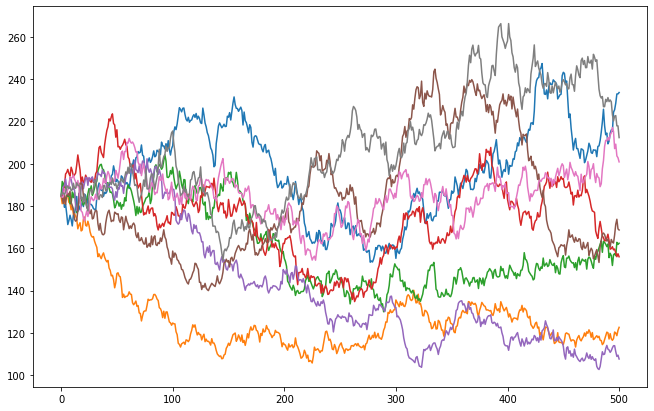

In [31]:
plt.figure(figsize = (11,7))
plt.plot(S[:,:8])

Exercise if ${S_t} - K > 0 $. We are using a strike price (K) = 200, at the end of the 2 years

In [29]:
payoff = np.maximum(S[-1] - 200,0)

## $C = \frac{e^{- r.T}.\sum{p_i}}{iterations} $

In [30]:
call_option = np.exp(- r * T) * np.sum(payoff) / iterations
call_option

20.025232666065737

At the end of the 2 years, we should hopefully exercise the Call Option as we are getting a positive payoff. This is a more sophisticated way of calculating the value of a call option as compared to the Black Scholes Model as we are using the average of thousands of different pssible scenarios.